# SDP Schedule Simulation

In [1]:
import sys
import math
import random
import time
import warnings
import numpy
from ipywidgets import interact_manual, SelectMultiple
from IPython.display import display, Markdown
from matplotlib import pylab
import matplotlib.lines

sys.path.insert(0, "..")
from sdp_par_model.scheduling import efficiency

from sdp_par_model import reports, config
from sdp_par_model.scheduling import graph, level_trace, scheduler
from sdp_par_model.parameters import definitions
from sdp_par_model.parameters.definitions import Telescopes, Pipelines, Constants, HPSOs
from sdp_par_model import config

## Overall observatory selection & capacities

In [2]:
telescope = Telescopes.SKA1_Mid

# Assumptions about throughput per size for hot and cold buffer
hot_rate_per_size = 3 * Constants.giga / 10 / Constants.tera # 3 GB/s per 10 TB [NVMe SSD]
cold_rate_per_size = 0.5 * Constants.giga / 16 / Constants.tera # 0.5 GB/s per 16 TB [SATA SSD]

# Common system sizing
ingest_rate = 0.46 * Constants.tera # Byte/s
delivery_rate = int(100/8 * Constants.giga)  # Byte/s
lts_rate = delivery_rate

# Costing scenarios to assume
scenario = "low-adjusted"
batch_parallelism = 2
if scenario == 'low-cdr':
    telescope = Telescopes.SKA1_Low
    total_flops = int(13.8 * Constants.peta) # FLOP/s
    input_buffer_size = int((0.5 * 46.0 - 0.6) * Constants.peta) # Byte
    hot_buffer_size = int(0.5 * 46.0 * Constants.peta) # Byte
    delivery_buffer_size = int(0.656 * Constants.peta) # Byte
elif scenario == 'mid-cdr':
    telescope = Telescopes.SKA1_Mid
    total_flops = int(12.1 * Constants.peta) # FLOP/s
    input_buffer_size = int((0.5 * 39.0 - 1.103) * Constants.peta) # Byte
    hot_buffer_size = int(0.5 * 39.0 * Constants.peta) # Byte
    delivery_buffer_size = int(0.03 * 39.0 * Constants.peta) # Byte
elif scenario == 'low-adjusted':
    telescope = Telescopes.SKA1_Low
    total_flops = int(9.623 * Constants.peta) # FLOP/s
    # input_buffer_size = int(30.0 * Constants.peta) # Byte # 1
    input_buffer_size = int(43.35 * Constants.peta) # Byte
    #hot_buffer_size = int(17.5 * Constants.peta) # Byte # 1
    hot_buffer_size = int(25.5 * Constants.peta) # Byte # 2
    #hot_buffer_size = int(27.472 * Constants.peta) # Byte
    delivery_buffer_size = int(0.656 * Constants.peta) # Byte
elif scenario == 'mid-adjusted':
    telescope = Telescopes.SKA1_Mid
    total_flops = int(5.9 * Constants.peta) # FLOP/s
    input_buffer_size = int(48.455 * Constants.peta) # Byte
    hot_buffer_size = int(40.531 * Constants.peta) # Byte
    delivery_buffer_size = int(1.103 * Constants.peta) # Byte
else:
    assert False, "Unknown costing scenario {}!".format(scenario)

In [3]:
print("Scenario for {}:".format(telescope))
display(Markdown("""| &nbsp; | Input | Hot | Output | All |&nbsp;|\n|-|-:|-:|-:|-:|-|
| Sizes: | {:.2f} | {:.2f} | {:.2f} | {:.2f} | PB |
| Rates: | {:.2f} | {:.2f} | {:.2f} | {:.2f} | TB/s |
""".format(
    input_buffer_size / Constants.peta, hot_buffer_size / Constants.peta, delivery_buffer_size / Constants.peta,
    (input_buffer_size+hot_buffer_size+delivery_buffer_size) / Constants.peta,
    input_buffer_size * cold_rate_per_size / Constants.tera,
    hot_buffer_size * hot_rate_per_size / Constants.tera,
    delivery_buffer_size * cold_rate_per_size / Constants.tera,
    (input_buffer_size + delivery_buffer_size) * cold_rate_per_size / Constants.tera +
    hot_buffer_size * hot_rate_per_size / Constants.tera)))

Scenario for SKA1_Low:


| &nbsp; | Input | Hot | Output | All |&nbsp;|
|-|-:|-:|-:|-:|-|
| Sizes: | 43.35 | 25.50 | 0.66 | 69.51 | PB |
| Rates: | 1.35 | 7.65 | 0.02 | 9.03 | TB/s |


## Read HPSO performance characteristics

Loads high performance science objective characteristics generated by the export notebook. This always picks up the latest file checked into Git.

In [4]:
csv = reports.read_csv(reports.newest_csv(reports.find_csvs()))
csv = reports.strip_csv(csv)

## Determine computational capacity required for realtime processing

As SKA SDP needs to be able to change observation at arbitrary times, we need to always reserve enough computational resources to deal with the most expensive case. Here we figure this out automatically based on the calculated parameters.

In [5]:
realtime_flops = 0
realtime_flops_hpso = None
for hpso in definitions.HPSOs.all_hpsos:
    if definitions.HPSOs.hpso_telescopes[hpso] != telescope:
        continue
    # Sum FLOP rates over involved real-time pipelines
    rt_flops = 0
    for pipeline in definitions.HPSOs.hpso_pipelines[hpso]:
        cfg_name = config.PipelineConfig(hpso=hpso, pipeline=pipeline).describe()
        flops = int(math.ceil(float(reports.lookup_csv(csv, cfg_name, 'Total Compute Requirement')) * definitions.Constants.peta))
        if pipeline in definitions.Pipelines.realtime:
            rt_flops += flops
    # Dominates?
    if rt_flops > realtime_flops:
        realtime_flops = rt_flops
        realtime_flops_hpso = hpso
        
# Show
print("Realtime processing requirements:")
batch_flops = total_flops - realtime_flops
print(" {:.3f} Pflop/s real-time (from {}), {:.3f} Pflop/s left for batch".format(
    realtime_flops / definitions.Constants.peta,
    realtime_flops_hpso, batch_flops / definitions.Constants.peta))

Realtime processing requirements:
 1.761 Pflop/s real-time (from hpso01), 7.862 Pflop/s left for batch


## Derive capacities

Now that we know the split between batch and realtime processing, we can formulate the capacity dictionary that will be used in scheduling.

In [6]:
capacities = {
    graph.Resources.Observatory: 1,
    graph.Resources.BatchCompute: batch_flops,
    graph.Resources.RealtimeCompute: realtime_flops,
    graph.Resources.InputBuffer: input_buffer_size,
    graph.Resources.HotBuffer: hot_buffer_size,
    graph.Resources.OutputBuffer: delivery_buffer_size,
    graph.Resources.IngestRate: ingest_rate,
    graph.Resources.DeliveryRate: delivery_rate,
    graph.Resources.LTSRate: lts_rate
}
def update_rates(capacities):
    capacities[graph.Resources.HotBufferRate] = hot_rate_per_size * capacities[graph.Resources.HotBuffer]
    capacities[graph.Resources.InputBufferRate] = cold_rate_per_size * capacities[graph.Resources.InputBuffer]
    capacities[graph.Resources.OutputBufferRate] = cold_rate_per_size * capacities[graph.Resources.OutputBuffer]
update_rates(capacities)

## Generate graph

Generate a sequence with all HPSOs appearing roughly as often as we expect them in a real-life schedule. We then shuffle this list and generate a (multi-)graph of tasks from it.

Note that in contrast to Francois' scheduler, the resource usage of every task is fixed up-front, therefore we need to declare certain key sizes here. Adjust as necessary in relation to the capacities (see below) to get the desired amount of parallelism between tasks.

In [34]:
Tsequence = 1 * 24 * 3600
Tobs_min = 10 * 60

hpso_sequence, Tobs_sum = graph.make_hpso_sequence(telescope, Tsequence, Tobs_min, verbose=True)
print("{:.3f} d total".format(Tobs_sum / 3600 / 24))
# random.shuffle(hpso_sequence)

1 x hpso01 (Tobs=5.0h, Texp=5000.0h)
15 x hpso04a (Tobs=0.7h, Texp=12750.0h)
5 x hpso05a (Tobs=0.7h, Texp=4300.0h)
1 x hpso02b (Tobs=5.0h, Texp=5000.0h)
1 x hpso02a (Tobs=5.0h, Texp=5000.0h)
1.181 d total


In [35]:
t = time.time()
nodes = graph.hpso_sequence_to_nodes(csv, hpso_sequence, capacities, Tobs_min, batch_parallelism=batch_parallelism)
print("Multi-graph has {} nodes (generation took {:.3f}s)".format(len(nodes), time.time()-t))

Multi-graph has 137 nodes (generation took 0.033s)


In [36]:
if True:
    for node in nodes:
        print("{} ({}, t={} s)".format(node.name, node.hpso, node.time))
        for cost, amount in node.cost.items():
            if cost in graph.Resources.units:
                unit, mult = graph.Resources.units[cost]
                print(" {}={:.2f} {}".format(cost, amount/mult, unit))
        for cost, amount in node.edge_cost.items():
            if cost in graph.Resources.units:
                unit, mult = graph.Resources.units[cost]
                print(" -> {}={:.2f} {}".format(cost, amount/mult, unit))
        print()

Ingest + RCAL + FastImg (hpso01, t=18000 s)
 realtime-compute=1.76 PFLOP/s
 input-rate=0.46 TB/s
 ingest-rate=0.46 TB/s
 -> input-buffer=8.26 PB

Stage Measurements (input -> hot) (hpso01, t=9235.00477617045 s)
 input-rate=0.89 TB/s
 hot-rate=0.89 TB/s
 -> hot-buffer=8.26 PB

ICAL + DPrepA + DPrepB + DPrepC + DPrepD (hpso01, t=78562 s)
 batch-compute=3.93 PFLOP/s
 hot-rate=2.57 TB/s
 -> hot-buffer=0.22 PB

Stage Data Products (hot -> output) (hpso01, t=28105.763301715375 s)
 hot-rate=0.01 TB/s
 output-rate=0.01 TB/s
 -> output-buffer=0.22 PB

Deliver Data Products (hpso01, t=17987.68851309784 s)
 output-rate=0.01 TB/s
 delivery-rate=0.01 TB/s

Sequence (hpso01, t=0 s)

Ingest + RCAL + FastImg (hpso04a, t=2400 s)
 realtime-compute=0.97 PFLOP/s
 input-rate=0.46 TB/s
 ingest-rate=0.46 TB/s
 -> input-buffer=0.00 PB

Stage Measurements (input -> hot) (hpso04a, t=2.349593573174991 s)
 input-rate=0.89 TB/s
 hot-rate=0.89 TB/s
 -> hot-buffer=0.00 PB

PSS (hpso04a, t=0 s)
 batch-compute=1.93 PF

## Sanity-check Graph

We can do a number of consistency checks at this point: Clearly we should have enough capacity to run every task in isolation.

Furthermore, in order to keep up with observations we need to make sure that we are not over-using any resource on average. This is a pretty rough estimate of safety that especially under-estimates the cost of edges in high-pressure scenarios. For example, if somethings needs to be kept in the buffer for longer, it has a higher footprint than estimated here. Therefore especially the size of `input-buffer` and `output-buffer` should be quite generous here.

In [37]:
cost_sum = { cost : 0 for cost in capacities.keys() }
for task in nodes:
    for cost, amount in task.all_cost().items():
        assert cost in capacities, "No {} capacity defined, required by {}!".format(cost, task.name)
        assert amount <= capacities[cost], "Not enough {} capacity to run {} ({:g}<{:g}!)".format(
            cost, task.name, capacities[cost], amount)
        # Try to compute an average. Edges are the main wild-card here: We only know that they stay
        # around at least for the lifetime of the dependency *and* the longest dependent task.
        ttime = task.time
        if cost in task.edge_cost and len(task.rev_deps) > 0:
            ttime += max([d.time for d in task.rev_deps])
        cost_sum[cost] += ttime * amount
print("Best-case average loads:")
for cost in graph.Resources.All:
    unit, mult = graph.Resources.units[cost]
    avg = cost_sum[cost] / Tobs_sum
    cap = capacities[cost]
    print(" {}:\t{:.3f} {} ({:.1f}% of {:.3f} {})".format(cost, avg/mult, unit, avg/cap*100, cap/mult, unit))
    # Warn past 75%
    if avg > cap:
        print('Likely insufficient {} capacity!'.format(cost), file=sys.stderr,)

Best-case average loads:
 batch-compute:	8.072 PFLOP/s (102.7% of 7.862 PFLOP/s)
 realtime-compute:	1.387 PFLOP/s (78.7% of 1.761 PFLOP/s)
 input-buffer:	8.864 PB (20.4% of 43.350 PB)
 hot-buffer:	43.841 PB (171.9% of 25.500 PB)
 output-buffer:	0.424 PB (64.6% of 0.656 PB)
 ingest-rate:	0.459 TB/s (99.8% of 0.460 TB/s)
 input-rate:	0.702 TB/s (51.8% of 1.355 TB/s)
 hot-rate:	5.520 TB/s (72.2% of 7.650 TB/s)
 output-rate:	0.013 TB/s (65.2% of 0.021 TB/s)
 delivery-rate:	0.007 TB/s (53.5% of 0.013 TB/s)
 lts-rate:	0.000 TB/s (0.0% of 0.013 TB/s)


Likely insufficient batch-compute capacity!
Likely insufficient hot-buffer capacity!


## Schedule tasks

Assign a task time to every node, and figure out resource usages and edge lengths along the way.

In [38]:
t = time.time()
usage, task_time, task_edge_end_time = scheduler.schedule(nodes, capacities, verbose=True)
print("Scheduling took {:.3f}s".format(time.time() - t))
print("Observing efficiency: {:.1f}%".format(Tobs_sum / usage[graph.Resources.Observatory].end() * 100))
total = 0
for key in task_edge_end_time:
    total += key.time
max(*task_edge_end_time.values())/3600/24

=> Ingest + RCAL + FastImg: 0-18000
=> Stage Measurements (input -> hot): 18000-27235.004776170448
=> ICAL + DPrepA + DPrepB + DPrepC + DPrepD: 27235.004776170448-105797.00477617045
=> Stage Data Products (hot -> output): 105797.00477617045-133902.76807788582
=> Deliver Data Products: 133902.76807788582-151890.45659098367
=> Sequence: 18000-18000
=> Ingest + RCAL + FastImg: 18000-20400
input-rate for Stage Measurements (input -> hot) (2.349593573174991 s): Amount 894687500000.0 @ 27235.004776170448
=> Stage Measurements (input -> hot): 27235.004776170448-27237.35436974362
=> PSS: 27237.35436974362-27237.35436974362
=> Stage Data Products (hot -> output): 27237.35436974362-27264.193769743622
=> Deliver Data Products: 27264.193769743622-27281.370985743622
=> Sequence: 20400-20400
=> Ingest + RCAL + FastImg: 20400-22800
input-rate for Stage Measurements (input -> hot) (2.349593573174991 s): Amount 894687500000.0 @ 27237.35436974362
=> Stage Measurements (input -> hot): 27237.35436974362-2

2.57839648832157

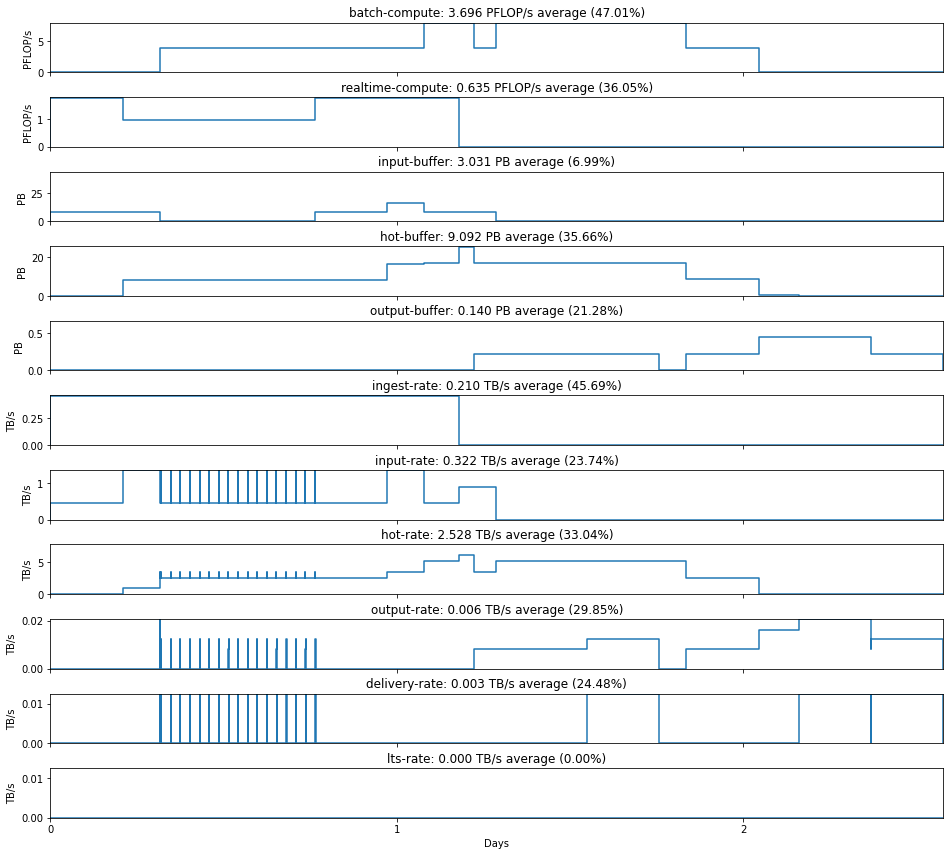

In [42]:
trace_end = max(*task_edge_end_time.values())
pylab.figure(figsize=(16,16)); pylab.subplots_adjust(hspace=0.5)
for n, cost in enumerate(graph.Resources.All):
    levels = usage[cost]
    avg = levels.average(0,trace_end)    
    unit, mult = graph.Resources.units[cost]
    pylab.subplot(len(usage), 1, n+1)
    pylab.step([0] + [ t/24/3600 for t in levels._trace.keys() ] + [trace_end],
               [0] + [ v/mult for v in  levels._trace.values() ] + [0],
               where='post')
    pylab.title("{}: {:.3f} {} average ({:.2f}%)".format(
        cost, avg/mult, unit, avg / capacities[cost] * 100))
    pylab.xlim((0, trace_end/24/3600)); pylab.xticks(range(int(trace_end)//24//3600+1))
    pylab.ylim((0, capacities[cost] / mult * 1.01))
    pylab.ylabel(unit)
    if n + 1 < len(graph.Resources.All):
        pylab.gca().xaxis.set_ticklabels([])
pylab.xlabel("Days")
pylab.show()

## Efficiency calculations

We can play around with capacities and see how it affects overall efficiency. This takes quite a bit, so let's set up some multiprocessing infrastructure to take advantage of parallelism:

In [33]:
import multiprocessing
interesting_costs = [ graph.Resources.BatchCompute, graph.Resources.InputBuffer,
                      graph.Resources.HotBuffer, graph.Resources.OutputBuffer]
linked_cost = {
    graph.Resources.HotBuffer : graph.Resources.HotBufferRate,
    graph.Resources.InputBuffer : graph.Resources.InputBufferRate,
    graph.Resources.OutputBuffer : graph.Resources.OutputBufferRate,
}
# Assumed price to add capacity
cost_gradient = {
    graph.Resources.BatchCompute : 1850000 / Constants.peta,
    graph.Resources.RealtimeCompute : 1850000 / Constants.peta,
    graph.Resources.HotBuffer    : 80000 / Constants.peta,
    graph.Resources.InputBuffer  : 45000 / Constants.peta,
    graph.Resources.OutputBuffer : 45000 / Constants.peta,
}
# Assumed price of entire telescope to assign cost to inefficiences
total_cost = 250*Constants.mega
@interact_manual(costs=SelectMultiple(options=graph.Resources.All, value=interesting_costs),
                 percent=(1,100,1), percent_step=(1,10,1), count=(1,100,1), yaxis_range=(1, 20, 1),
                 batch_parallelism = (1,10,1))
def test_sensitivity(costs=interesting_costs, percent=50, percent_step=5, count=multiprocessing.cpu_count(),
                     batch_parallelism=batch_parallelism, yaxis_range=5, cost_change=False):
    # Calculate
    lengths = efficiency.determine_durations_batch(csv,
        hpso_sequence, costs, capacities, update_rates, percent, percent_step, count,
        Tobs_min=Tobs_min, batch_parallelism=batch_parallelism)
    # Make graph
    graph_count = len(costs)
    pylab.figure(figsize=(8,graph_count*4))
    pylab.subplots_adjust(hspace=0.4)
    for graph_ix, cost in enumerate(costs):
        pylab.subplot(graph_count, 1, graph_ix+1)
        efficiency.plot_efficiencies(pylab.gca(), Tobs_sum, cost, capacities[cost], lengths[cost],
                                     linked_cost.get(cost), update_rates,
                                     cost_gradient.get(cost) if cost_change else None, total_cost)

interactive(children=(SelectMultiple(description='costs', index=(0, 2, 3, 4), options=('batch-compute', 'realt…

## Dealing with failures

It is also possible to simulate failures. The idea is that we model this as a temporary capacity change, which requires us to re-schedule twice (once the capacity reduces, and once it's restored)

In [ ]:
scheduler.schedule(nodes, capacities, task_time, task_edge_end_time, verbose=True);

In [ ]:
new_capacities = dict(capacities)
new_capacities[graph.Resources.InputBuffer] = capacities[graph.Resources.InputBuffer] // 2
usage2, task_time2, task_edge_end_time2, failed_usage2 = scheduler.reschedule(
    nodes, new_capacities, 5*24*3600, task_time, task_edge_end_time, verbose=False)
usage3, task_time3, task_edge_end_time3, failed_usage3 = scheduler.reschedule(
    nodes, capacities, 8*24*3600, task_time2, task_edge_end_time2, verbose=False)

In [ ]:
trace_end = max(*task_edge_end_time3.values())
pylab.figure(figsize=(16,16)); pylab.subplots_adjust(hspace=0.5)
for n, cost in enumerate(graph.Resources.All):
    levels = usage3[cost]
    avg = levels.average(0,trace_end)    
    unit, mult = graph.Resources.units[cost]
    pylab.subplot(len(usage), 1, n+1)
    for levels in [failed_usage2[cost] + failed_usage3[cost] + usage3[cost], failed_usage2[cost] + failed_usage3[cost]]:
        pylab.step([0] + [ t/24/3600 for t in levels._trace.keys() ] + [trace_end],
                   [0] + [ v/mult for v in  levels._trace.values() ] + [0],
                   where='post')
    pylab.title("{}: {:.3f} {} average ({:.2f}%)".format(
        cost, avg/mult, unit, avg / capacities[cost] * 100))
    pylab.xlim((0, trace_end/24/3600)); pylab.xticks(range(int(trace_end)//24//3600+1))
    pylab.ylim((0, capacities[cost] / mult * 1.01))
    pylab.ylabel(unit)
    if n + 1 < len(graph.Resources.All): pylab.gca().xaxis.set_ticklabels([])    
pylab.xlabel("Days")
pylab.show()